# Random Forest

The `conifer` package was created out of `hls4ml`, providing a similar set of features but specifically targeting inference of random forest. In this notebook we will train a `RandomForestClassifier` with scikit-learn, using the MNIST dataset. Then we will convert the model using `conifer`, and run bit-accurate prediction and synthesis.

`conifer` is available from GitHub [here](https://github.com/thesps/conifer), and we have a publication describing the inference implementation and performance in detail [here](https://iopscience.iop.org/article/10.1088/1748-0221/15/05/P05026/pdf).


In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib
import conifer
import plotting
import matplotlib.pyplot as plt
import os
os.environ['XILINX_VIVADO']='/home/rrk307/Xilinx/Vivado/2018.3'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
np.random.seed(0)

runtime module could not be imported. Interacting with FPUs will not be possible.


### Random Forest MNIST

In [2]:
#https://www.kaggle.com/code/ashwani07/mnist-classification-using-random-forest/notebook
import pandas as pd
import os
train = pd.read_csv("/home/rrk307/MNIST_dataset/train.csv")
test = pd.read_csv("/home/rrk307/MNIST_dataset/test.csv")

In [3]:
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.model_selection import cross_val_score
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))
print ("Testing dataset has %i observations and %i variables" %(test.shape[0], test.shape[1]))
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=0)
(X_train, X_test, y_train, y_test) = X_train.values, X_test.values, y_train.values, y_test.values
print(X_train.shape)
print(X_test.shape)
rf=RandomForestClassifier(n_estimators=3, max_depth=5, random_state=0)
rf.fit(X_train,y_train)
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

Training dataset has 42000 observations and 785 variables
Testing dataset has 28000 observations and 784 variables
(33600, 784)
(8400, 784)
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       813
           1       0.79      0.97      0.87       961
           2       0.74      0.72      0.73       860
           3       0.70      0.69      0.70       863
           4       0.61      0.62      0.61       827
           5       0.70      0.37      0.48       756
           6       0.79      0.76      0.77       841
           7       0.65      0.73      0.68       899
           8       0.66      0.66      0.66       768
           9       0.52      0.52      0.52       812

    accuracy                           0.70      8400
   macro avg       0.70      0.69      0.69      8400
weighted avg       0.70      0.70      0.69      8400

Confusion Report
[[727   1  11   7   8   4  13   6  30   6]
 [  0 930   7   4  

#### Profiling Accuracy for various RF architecture

#### Rounding the thresholds to nearest integer values before encryption. Verifying that rounding operation maintains the accuracy.

In [4]:
for i,dt in enumerate(rf.estimators_):
    print('Minimum and maximum threshold value is ',min(dt.tree_.threshold), max(dt.tree_.threshold))
        
for i,dt in enumerate(rf.estimators_):
    for j,thd in enumerate(dt.tree_.threshold):
        rf.estimators_[i].tree_.threshold[j] = int(round(thd))
        
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

print('Thresholds of decision trees')
for i,dt in enumerate(rf.estimators_):
    print(dt.tree_.threshold)

Minimum and maximum threshold value is  -2.0 191.5
Minimum and maximum threshold value is  -2.0 191.5
Minimum and maximum threshold value is  -2.0 208.0
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       813
           1       0.79      0.97      0.87       961
           2       0.75      0.72      0.74       860
           3       0.70      0.69      0.70       863
           4       0.61      0.62      0.61       827
           5       0.69      0.37      0.49       756
           6       0.79      0.76      0.77       841
           7       0.64      0.73      0.68       899
           8       0.66      0.66      0.66       768
           9       0.52      0.52      0.52       812

    accuracy                           0.70      8400
   macro avg       0.70      0.69      0.69      8400
weighted avg       0.70      0.70      0.69      8400

Confusion Report
[[726   1  11   7   8   5  14   6  29   6]
 [  0 

##### Deeper trees

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
train_acc = {}
val_acc = {}
test_acc = {}
nodes_count = {}
leaves_count = {}
rf_clf = {}
for n_tree in range(3,20,2):
    for depth in range(5,12,2):
        print(f'Testing for {(n_tree,depth)}.')
        rf_clf[(n_tree,depth)] = RandomForestClassifier(n_estimators=n_tree, max_depth=depth)

        y_train_pred = cross_val_predict(rf_clf[(n_tree,depth)], X_train, y_train, cv=2)
        rf_clf[(n_tree,depth)].fit( X_train, y_train)

        from sklearn.model_selection import cross_val_score
        train_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_train, y_train, cv=2, scoring="accuracy"))
        val_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_val, y_val, cv=2, scoring="accuracy"))
        test_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_test, y_test, cv=2, scoring="accuracy"))
        nodes_count[(n_tree,depth)] = [tree_i.tree_.node_count for tree_i in rf_clf[(n_tree,depth)].estimators_]
        leaves_count[(n_tree,depth)] = [tree_i.tree_.n_leaves for tree_i in rf_clf[(n_tree,depth)].estimators_]

Testing for (3, 5).
Testing for (3, 7).
Testing for (3, 9).
Testing for (3, 11).
Testing for (5, 5).
Testing for (5, 7).
Testing for (5, 9).
Testing for (5, 11).
Testing for (7, 5).
Testing for (7, 7).
Testing for (7, 9).
Testing for (7, 11).
Testing for (9, 5).
Testing for (9, 7).
Testing for (9, 9).
Testing for (9, 11).
Testing for (11, 5).
Testing for (11, 7).
Testing for (11, 9).
Testing for (11, 11).
Testing for (13, 5).
Testing for (13, 7).
Testing for (13, 9).
Testing for (13, 11).
Testing for (15, 5).
Testing for (15, 7).
Testing for (15, 9).
Testing for (15, 11).
Testing for (17, 5).
Testing for (17, 7).
Testing for (17, 9).
Testing for (17, 11).
Testing for (19, 5).
Testing for (19, 7).
Testing for (19, 9).
Testing for (19, 11).


In [8]:
print('Training accuracy: ',train_acc)
print('======================')
print('Validation accuracy: ',val_acc)
print('======================')
print('Testing accuracy: ',test_acc)
print('======================')
print('Nodes count: ',nodes_count)
print('======================')
print('Leaves count: ',leaves_count)

Training accuracy:  {(3, 5): 0.6940569196428572, (3, 7): 0.7835751488095237, (3, 9): 0.8204520089285714, (3, 11): 0.8276134672619048, (5, 5): 0.7523716517857142, (5, 7): 0.8344494047619048, (5, 9): 0.8625837053571428, (5, 11): 0.8731398809523809, (7, 5): 0.7871558779761905, (7, 7): 0.8530970982142857, (7, 9): 0.8846726190476191, (7, 11): 0.8964378720238095, (9, 5): 0.8079427083333333, (9, 7): 0.8666759672619048, (9, 9): 0.8935546875, (9, 11): 0.9070870535714286, (11, 5): 0.8086867559523809, (11, 7): 0.8717912946428572, (11, 9): 0.9027157738095238, (11, 11): 0.9109002976190477, (13, 5): 0.8134300595238095, (13, 7): 0.8782552083333333, (13, 9): 0.9062034970238095, (13, 11): 0.9214099702380952, (15, 5): 0.8296595982142857, (15, 7): 0.8830915178571428, (15, 9): 0.9097377232142857, (15, 11): 0.9212239583333333, (17, 5): 0.8223586309523809, (17, 7): 0.8879743303571428, (17, 9): 0.9143880208333333, (17, 11): 0.9223400297619047, (19, 5): 0.8288690476190477, (19, 7): 0.8888578869047619, (19, 9)

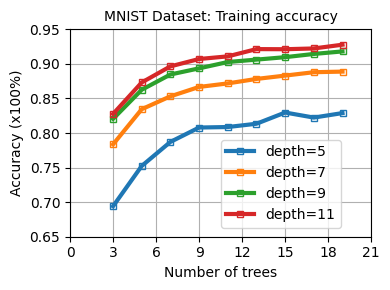

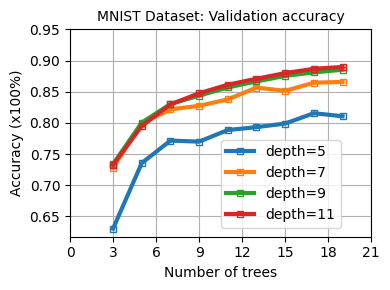

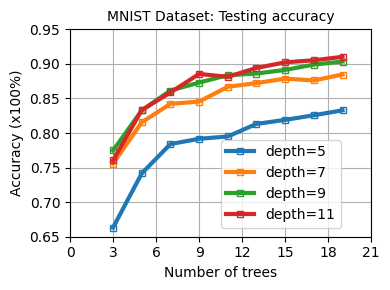

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in train_acc.keys()]):
    plt.plot(np.unique([i[0] for i in train_acc.keys()]), [train_acc[j,depth] for j in np.unique([i[0] for i in train_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
    #plt.plot(np.unique([i[0] for i in val_acc.keys()]), [val_acc[j,depth] for j in np.unique([i[0] for i in val_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Training accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_MNIST_train.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in val_acc.keys()]):
    plt.plot(np.unique([i[0] for i in val_acc.keys()]), [val_acc[j,depth] for j in np.unique([i[0] for i in val_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Validation accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_MNIST_val.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in test_acc.keys()]):
    plt.plot(np.unique([i[0] for i in test_acc.keys()]), [test_acc[j,depth] for j in np.unique([i[0] for i in test_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Testing accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_MNIST_test.pdf')
plt.show()